In [ ]:
#!pip install grad-cam
#!pip install torchmetrics

In [18]:
# Common imports
import os
import numpy as np
import pandas as pd
from glob import glob
import torch
import torchvision.transforms as transforms
from PIL import Image

# Data
from torchvision.transforms.functional import resize, to_tensor

# Data Viz
import matplotlib.pyplot as plt

# Model
import torch.nn as nn
import torch.nn.functional as F

# Callbacks
from pytorch_grad_cam import GradCAM

# Metrics
from torchmetrics import JaccardIndex


In [17]:
def load_image(image, SIZE):
    img = Image.open(image)
    img_array = to_tensor(resize(img, (SIZE, SIZE)))
    return torch.round(img_array, decimals=4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = torch.zeros((len(image_paths), 1, SIZE, SIZE))  # Channel-first for PyTorch
    else:
        images = torch.zeros((len(image_paths), 3, SIZE, SIZE))

    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:1, :, :]  # Select the first channel for mask
        else:
            images[i] = img

    return images

In [176]:
def show_image(image, title=None, cmap=None, alpha=1):
    # Rearrange dimensions for Matplotlib (if necessary)
    if image.ndim == 3 and image.shape[0] <= 4:  # Assuming channels-first if channels are <= 4
        image = np.transpose(image, (1, 2, 0))

    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
  # Convert both image and mask to NumPy arrays and rearrange dimensions
  image_np = image.cpu().numpy()  # Move to CPU if on GPU
  image_np = np.transpose(image_np, (1, 2, 0)) 

  mask_np = mask.cpu().numpy()  # Move to CPU if on GPU

  # Check if mask has only 2 dimensions and skip transpose if so
  if mask_np.ndim == 3 and mask_np.shape[0] == 1:  
      mask_np = mask_np.squeeze(0)
  else:
      mask_np = np.transpose(mask_np, (1, 2, 0)) 

  plt.imshow(image_np)
  plt.imshow(mask_np, cmap=cmap, alpha=alpha)
  plt.axis('off')
  plt.show()

In [177]:
SIZE = 256

In [178]:
root_path = 'C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [179]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])


In [180]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

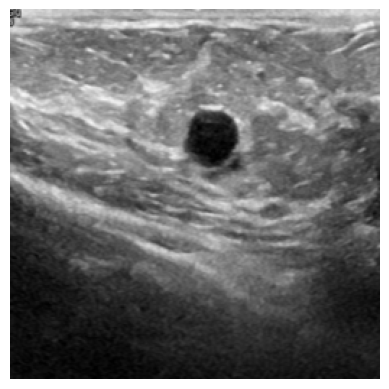

In [181]:
show_image(load_image(image_paths[7], SIZE))

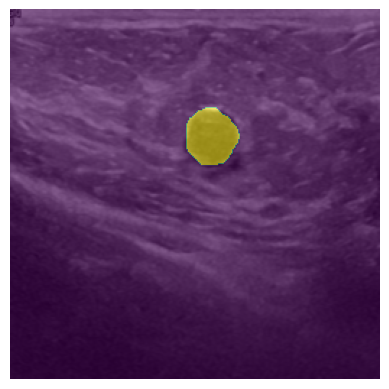

In [182]:
show_mask(load_image(image_paths[7], SIZE), load_image(mask_paths[7], SIZE), alpha=0.6)

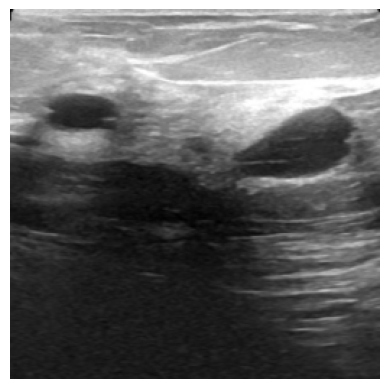

In [183]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

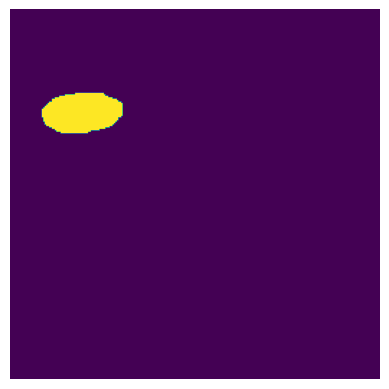

In [184]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

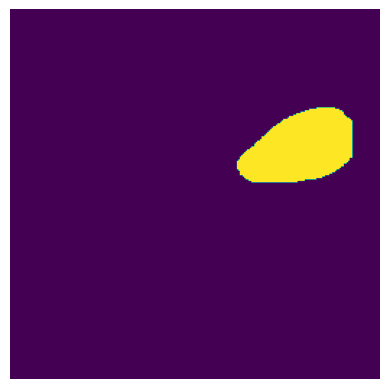

In [185]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

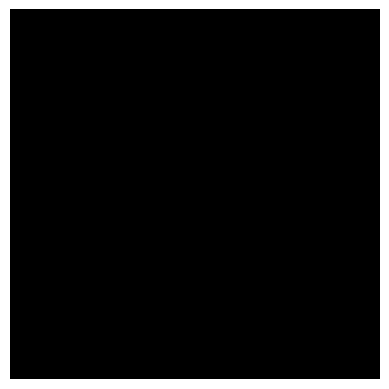

In [186]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)


# Add a batch dimension to masks
mask1 = mask1[np.newaxis, ...]
mask2 = mask2[np.newaxis, ...]

# Squeeze the channel dimension of the masks (if they are single-channel)
mask1 = mask1.squeeze(1)
mask2 = mask2.squeeze(1)

# Add a channel dimension to the masks
mask1 = np.expand_dims(mask1, -1) 
mask2 = np.expand_dims(mask2, -1)

# Repeat the masks along the channel dimension to match img
mask1 = np.repeat(mask1, 3, axis=-1) 
mask2 = np.repeat(mask2, 3, axis=-1) 

img = np.concatenate((img, mask1, mask2), axis=0)
img = img[0,:,:,0]  # Assuming you only want the first channel after concatenation
show_image(img, cmap='gray')

In [188]:


# ... (rest of the `show_image`, `show_mask` functions remain largely the same)

# ... (Loading images and dataset preparation is similar)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, rate, pooling=True):
        super(EncoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(rate)
        self.pool = nn.MaxPool2d(2) if pooling else nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.dropout(x)
        pooled_x = self.pool(x)
        return pooled_x, x  # Return both pooled and unpooled features

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, rate):
        super(DecoderBlock, self).__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = EncoderBlock(in_channels * 2, out_channels, rate, pooling=False)  # Concatenate skip connection

    def forward(self, x, skip_x):
        x = self.up(x)
        x = torch.cat([x, skip_x], dim=1)  # Concatenate along the channel dimension
        x = self.conv(x)
        return x

class AttentionGate(nn.Module):
    def __init__(self, in_channels, bn=True):
        super(AttentionGate, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.bn = nn.BatchNorm2d(in_channels) if bn else nn.Identity()

    def forward(self, x, skip_x):
        g = self.conv1(x)
        x = self.conv2(skip_x)
        x = F.relu(g + x)
        x = self.conv3(x)
        alpha = self.sigmoid(x)
        alpha = self.up(alpha)
        x = alpha * skip_x
        return self.bn(x)

# ... (Rest of the model definition using these PyTorch blocks)


In [194]:
import torch
import torch.nn as nn

# Assuming you've already defined EncoderBlock, DecoderBlock, and AttentionGate classes

class BreastCancerAttentionUNet(nn.Module):
    def __init__(self, input_shape):
        super(BreastCancerAttentionUNet, self).__init__()

        # Encoder
        self.encoder1 = EncoderBlock(input_shape[0], 32, 0.1, name="Encoder1")
        self.encoder2 = EncoderBlock(32, 64, 0.1, name="Encoder2")
        self.encoder3 = EncoderBlock(64, 128, 0.2, name="Encoder3")
        self.encoder4 = EncoderBlock(128, 256, 0.2, name="Encoder4")

        # Encoding
        self.encoding = EncoderBlock(256, 512, 0.3, pooling=False, name="Encoding")

        # Attention + Decoder
        self.attention1 = AttentionGate(256, bn=True, name="Attention1")
        self.decoder1 = DecoderBlock(512, 256, 0.2, name="Decoder1")

        self.attention2 = AttentionGate(128, bn=True, name="Attention2")
        self.decoder2 = DecoderBlock(256, 128, 0.2, name="Decoder2")

        self.attention3 = AttentionGate(64, bn=True, name="Attention3")
        self.decoder3 = DecoderBlock(128, 64, 0.1, name="Decoder3")

        self.attention4 = AttentionGate(32, bn=True, name="Attention4")
        self.decoder4 = DecoderBlock(64, 32, 0.1, name="Decoder4")

        # Output
        self.output_layer = nn.Conv2d(32, 1, kernel_size=1, padding='same')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        p1, c1 = self.encoder1(x)
        p2, c2 = self.encoder2(p1)
        p3, c3 = self.encoder3(p2)
        p4, c4 = self.encoder4(p3)

        # Encoding
        encoding = self.encoding(p4)

        # Attention + Decoder
        a1 = self.attention1(encoding, c4)
        d1 = self.decoder1(encoding, a1)

        a2 = self.attention2(d1, c3)
        d2 = self.decoder2(d1, a2)

        a3 = self.attention3(d2, c2)
        d3 = self.decoder3(d2, a3)

        a4 = self.attention4(d3, c1)
        d4 = self.decoder4(d3, a4)

        # Output
        output = self.output_layer(d4)
        output = self.sigmoid(output)
        return output

# Create the model
input_shape = (3,255,255)  # Get the shape from your 'images' data
model = BreastCancerAttentionUNet(input_shape)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Metrics (assuming you have a 'iou' metric defined)
metrics = ['accuracy', iou]

TypeError: EncoderBlock.__init__() got an unexpected keyword argument 'name'

In [ ]:

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Metrics
iou_metric = JaccardIndex(num_classes=2).to(device)  # Assuming you're using a GPU, move metric to the same device

# Training loop
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # Calculate metrics
        iou = iou_metric(outputs, masks)

        # ... (Print loss, accuracy, IoU, etc.)

# ... (Rest of the training and evaluation code)